# Medical Insurance Dataset Analysis
---
### William Hayward

The goal of this notebook is to perform some exploratory data analysis on this sample dataset from Kaggle (by user Mosap Abdel-Ghany). Here I will look to find any patterns, trends, or short-comings in this dataset, with the overall goal of modelling the charges accumulated by a given person based on these parameters, and producing some machine learning models.

---
## Exploratory Data Analysis
---

In [ ]:
# Import standard data science libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge

seed = 50

np.random.seed(seed)

sns.set(style = "darkgrid")

In [185]:
# Read in csv file
df = pd.read_csv(r"insurance.csv").sort_values("smoker", ascending = True)

# First look at dataset
display(df.head())

print("\n")

# Basic summary info
display(df.describe())

print("\n")

# Check for nulls
print(df.info())

# Define numerical and categorical variables
numerical = ["age", "bmi", "charges", "children"]

,age,sex,bmi,children,smoker,region,charges
556,46,male,33.440,1,no,northeast,8334.58960
724,50,female,27.075,1,no,northeast,10106.13425
1197,41,male,33.550,0,no,southeast,5699.83750
726,41,male,28.405,1,no,northwest,6664.68595
728,18,female,40.280,0,no,northeast,2217.60120


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010




<class 'pandas.core.frame.DataFrame'>
Index: 1338 entries, 556 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB
None


From inital inspection, there are no missing values or nulls in the dataset, so no imputing will be required here. We have 6 given variables (age, sex, bmi, children, smoker, region) and the one target variable (charges). Of the given variables we will use to model, 3 are numerical (age, bmi, children) and 3 are categorical (sex, smoker, region). For the purposes of plotting, I will be treating the children variable as a categorical due to there only being 6 different values, but in principle, this range could extend to more than the current limit of 5 children, so will be treated as numerical for modelling. We will need to look at these cases and scale/encode them appropriately.

---
### Univariate Analysis
---

We will now look at the distribution of the data and check for outliers.

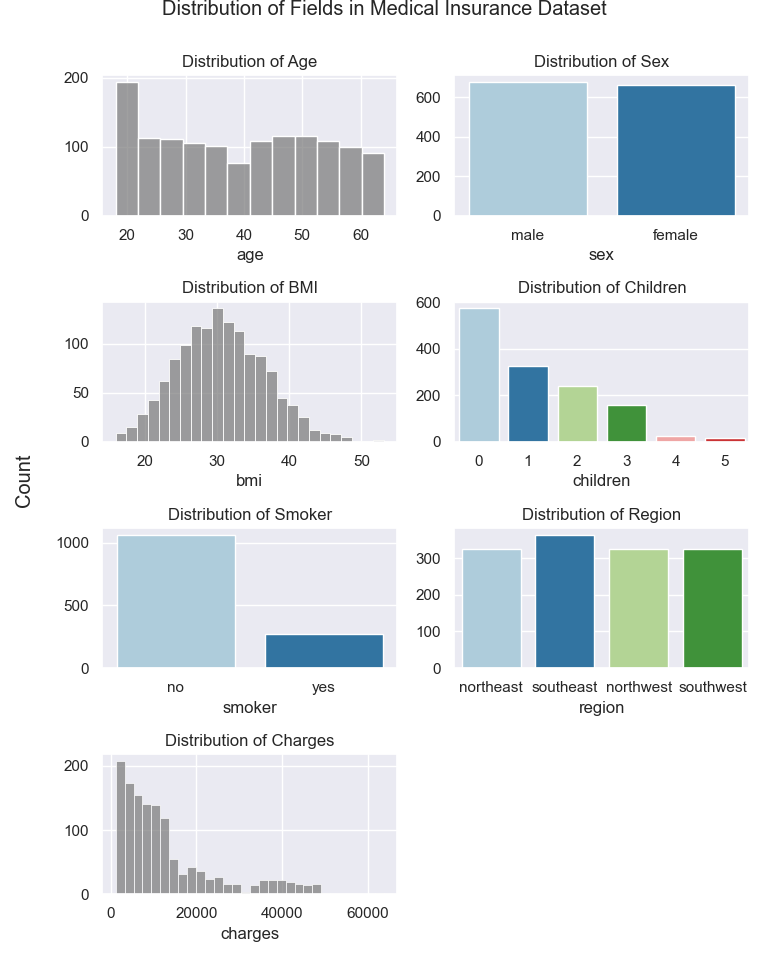

In [186]:
# First we do some EDA and see the distribution of the data

fig1, axes1 = plt.subplots(math.ceil(len(df.columns)/2), 2)

palette = "Paired"

# Remove extra plot for odd number of columns
if len(df.columns)%2 == 1:
    fig1.delaxes(axes1[-1,-1])

fig1.suptitle("Distribution of Fields in Medical Insurance Dataset", y = 1)
fig1.supylabel("Count")

for i, field in enumerate(df.columns):

    # Histplot for wider range numerical values
    if field in ["age", "bmi", "charges"]:
        sns.histplot(x = field, data = df, ax = axes1[i//2,i%2], color = "grey")
    # Countplot for categorical data or numerical with only a few values
    else:
        sns.countplot(x = field, data = df, ax = axes1[i//2,i%2], hue = field, palette = palette, legend = False)

    # Titles and axes labels for plots
    if field == "bmi":
        axes1[i//2,i%2].set_title(f"Distribution of {field.upper()}")
    else:
        axes1[i//2,i%2].set_title(f"Distribution of {field.capitalize()}")
    axes1[i//2,i%2].set_ylabel("")

# Layout of subplots
fig1.set_figheight(fig1.get_figheight()*2)
fig1.set_figwidth(fig1.get_figwidth()*1.2)
fig1.tight_layout()
plt.show()

There seems to be no obvious outliers in any of the distributions above. It is good to note that the BMI varaible seems to have a normal distribution, age a (nearly) uniform distribution, and children and charges a logarithmic distribution.

Next we look at some scatter and grouped bar plots to see the relation between each field and the target 'charges' variable. Note: After first plots, I identified that smoking had a clear impact on the charges values, so I found it more informative to plot smokers and non-smokers in different colours.

---
### Multivariate Analysis
---

We now look to see the relationships between variables and the target _charges_ variable. From domain knowledge, we can expect higher charges for smokers as smoking is associated with hightened risk for certain diseases/conditions, so we will plot smoker vs non-smokers in most plots below.

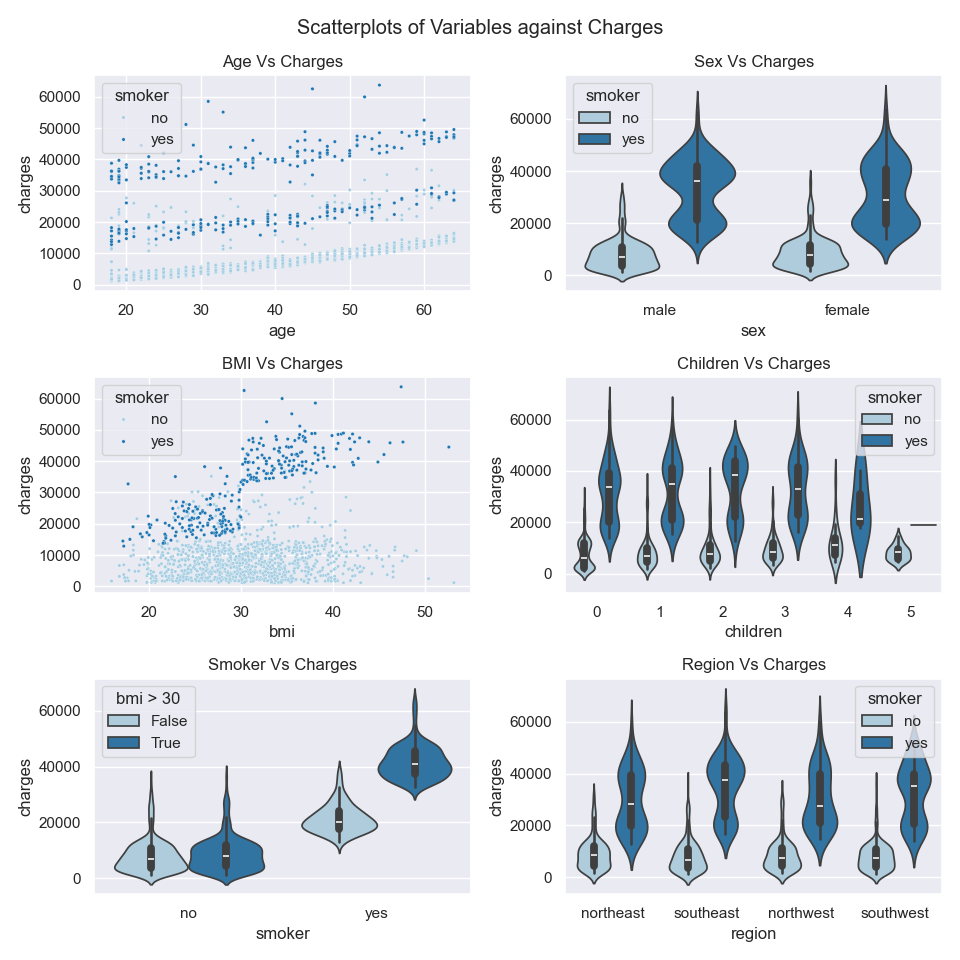

In [187]:
fig2, axes2 = plt.subplots(math.ceil((len(df.columns)-1)/2), 2)

fig2.suptitle("Scatterplots of Variables against Charges")

# Remove extra plot for odd number of columns
if (len(df.columns)-1)%2 == 1:
    fig2.delaxes(axes2[-1,-1])

# Plot all variables against charges
for i, field in enumerate(df.columns.drop(["charges"])):

    # Numerical variables: Will plot scatter plots
    if field in ["age", "bmi"]:
        sns.scatterplot(x = field, y = "charges", data = df, ax = axes2[i//2, i%2], marker = "o", s = 6, hue = "smoker", palette = palette)
    
    # Categorical variables: Will plot violin plots
    elif field == "smoker":
        data = df.copy()
        data["bmi > 30"] = df["bmi"].apply(lambda x: x > 30)
        sns.violinplot(x = "smoker", y = "charges", data = data, ax = axes2[i//2, i%2], hue = "bmi > 30", palette = palette)
    else:
        sns.violinplot(x = field, y = "charges", data = df, ax = axes2[i//2, i%2], hue = "smoker", palette = palette)

    axes2[i//2,i%2].set_title(f"{field.capitalize() if field != "bmi" else field.upper()} Vs Charges")

# Adjust fig parameters
fig2.set_figheight(fig2.get_figheight()*2)
fig2.set_figwidth(fig2.get_figwidth()*1.5)
fig2.tight_layout()
plt.show()

The scatter and bar plots above seem to confirm that smokers do see higher charges on average. Also, we see there seems to be some positive correlation for charges with the bmi (with smokers) and age varaibles. There also seems to be some significance to having a BMI over 30 for smokers. Due to this observation, I split the smoker violin plot by those above or below 30 BMI - this has made the correlation clearer. To investigate this further, we will look at both Pearson's and Spearman's correlations, again splitting the cases of smoker and non-smokers.

For the other categorical varaibles, there are some smaller trends that seem to be present for smokers, but these trends are less obvious so may not be as large a contributing factor. Additionally, there may be too few data points in our sample to give an accurate representation of the true population (especially for larger number of children).

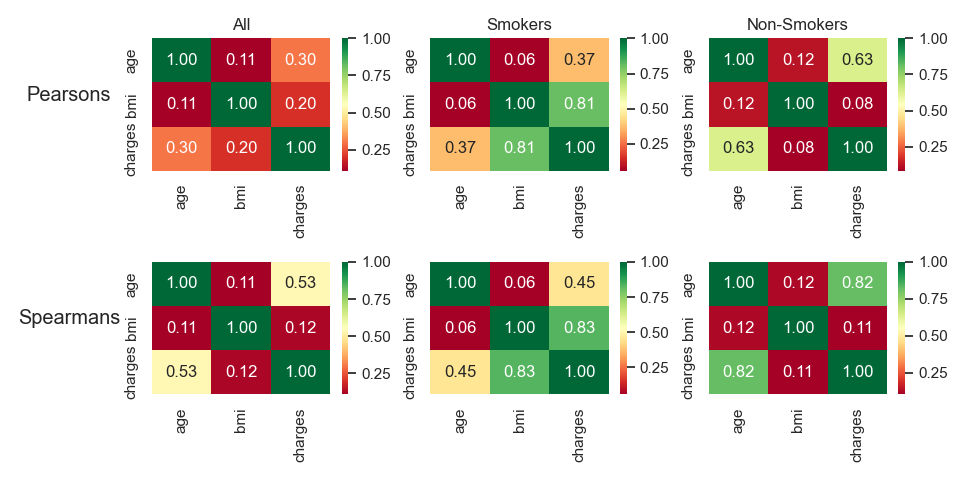

In [188]:
# Calculate correlation matrices for all, smokers and non-smokers
pcorr = df[["age","bmi","charges"]].corr()
pcorr_smoker = df[df["smoker"] == "yes"][["age","bmi","charges"]].corr()
pcorr_nonsmoker = df[df["smoker"] == "no"][["age","bmi","charges"]].corr()
scorr = df[["age","bmi","charges"]].corr("spearman")
scorr_smoker = df[df["smoker"] == "yes"][["age","bmi","charges"]].corr("spearman")
scorr_nonsmoker = df[df["smoker"] == "no"][["age","bmi","charges"]].corr("spearman")


# Plot heatmaps for each of these as heatmaps
fig3, axes3 = plt.subplots(2,3)

sns.heatmap(pcorr, annot = True, fmt = ".2f", cmap = "RdYlGn", ax=axes3[0,0])
sns.heatmap(pcorr_smoker, annot = True, fmt = ".2f", cmap = "RdYlGn", ax=axes3[0,1])
sns.heatmap(pcorr_nonsmoker, annot = True, fmt = ".2f", cmap = "RdYlGn", ax=axes3[0,2])
sns.heatmap(scorr, annot = True, fmt = ".2f", cmap = "RdYlGn", ax=axes3[1,0])
sns.heatmap(scorr_smoker, annot = True, fmt = ".2f", cmap = "RdYlGn", ax=axes3[1,1])
sns.heatmap(scorr_nonsmoker, annot = True, fmt = ".2f", cmap = "RdYlGn", ax=axes3[1,2])

axes3[0,0].set_title("All")
axes3[0,1].set_title("Smokers")
axes3[0,2].set_title("Non-Smokers")
axes3[0,0].set_ylabel("Pearsons", rotation = 0, size = "large", labelpad = 40)
axes3[1,0].set_ylabel("Spearmans", rotation = 0, size = "large", labelpad = 40)

fig3.set_figwidth(fig3.get_figwidth()*1.5)
fig3.tight_layout()
plt.show()

From the above correlation heatmaps, we can see that the bmi varaible seems to only have a strong, approximately linear correlation to the charges of smokers, and has little affect on non-smokers. Similarly the age seems to a more important (slightly non-linear) factor for non-smokers, with weaker correlation for smokers. This difference in importance may suggest models that could split the data early by smoking status may perform better (e.g.: decision trees).

This final plot give a 3D scatter for bmi, age and charges, with smokers in the legend. These seem to be the most defining varaibles in the model, so plotting this surface may give a better representation of what our models will be trying to replicate.

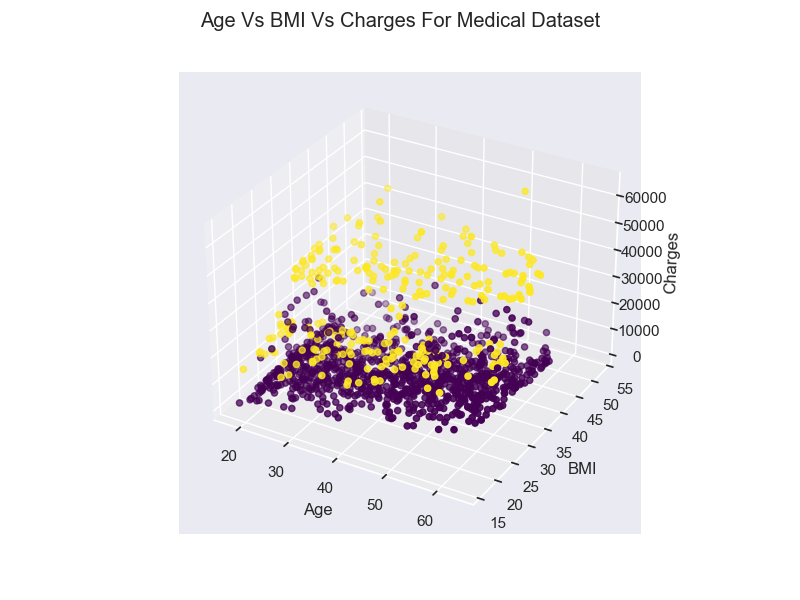

In [189]:
%matplotlib widget

fig4 = plt.figure(figsize=(8,6))

fig4.suptitle("Age Vs BMI Vs Charges For Medical Dataset")

axes4 = fig4.add_subplot(111,projection="3d")
axes4.scatter3D(xs = df["age"], ys = df["bmi"], zs = df["charges"], c=df["smoker"].apply(lambda x: x=="yes"), cmap="viridis")
axes4.set_ylabel("BMI")
axes4.set_xlabel("Age")
axes4.set_zlabel("Charges")
plt.show()

---
## Modelling
---

We now will look to use the insights above to 

In [197]:
def high_bmi(dfx):
    df = dfx.copy()
    df["high_bmi"] = df["bmi"].apply(lambda x: x > 30)
    return df

high_bmi_transformer = FunctionTransformer(high_bmi)

---
### Decision Tree (With SearchGridCV)
---

In [ ]:
numerical_pipe  = Pipeline([
    ("scale",StandardScaler()),
])

preprocessor = ColumnTransformer([
    ("numerical", numerical_pipe, numerical),
    ("one_hot", OneHotEncoder(), ["region"]),
    ("binary_encode", LabelEncoder(), ["sex", "smoker"])
])

model_pipe = Pipeline([
    ("feature_engineering", high_bmi_transformer),
    ("preprocessing",preprocessor),
    ("tree", DecisionTreeRegressor(random_state=seed))
])

param_grid = {
    "tree__max_depth":range(0,11),
    "tree__min_samples_split"
}
model_pipe.get_params()["tree"]

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [ ]:
# One-Hot encode the region variable
df = pd.get_dummies(df, columns = ["region"])

In [192]:
data = df.drop(columns=["charges"]).copy().to_numpy()
values = df["charges"].copy().to_numpy()

X_train, X_test, y_train, y_test = train_test_split(data, values, test_size = 0.2, random_state=seed)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1070, 9) (1070,) (268, 9) (268,)


In [ ]:
param_grid = {
    "max_depth":[2,5,10,25,50],
    "min_samples_split":[2,5,10,20],
    "min_samples_leaf":[3,5,10,30,50]
}

tree_model = DecisionTreeRegressor()
grid_search = GridSearchCV(tree_model, param_grid, cv=5)

grid_search.fit(X_train, y_train)

ValueError: 
All the 500 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Willi\Programming\Python\medicalInsurancePricing\medicalInsurancePricing\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Willi\Programming\Python\medicalInsurancePricing\medicalInsurancePricing\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Willi\Programming\Python\medicalInsurancePricing\medicalInsurancePricing\Lib\site-packages\sklearn\tree\_classes.py", line 1404, in fit
    super()._fit(
    ~~~~~~~~~~~~^
        X,
        ^^
    ...<2 lines>...
        check_input=check_input,
        ^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Willi\Programming\Python\medicalInsurancePricing\medicalInsurancePricing\Lib\site-packages\sklearn\tree\_classes.py", line 252, in _fit
    X, y = validate_data(
           ~~~~~~~~~~~~~^
        self, X, y, validate_separately=(check_X_params, check_y_params)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Willi\Programming\Python\medicalInsurancePricing\medicalInsurancePricing\Lib\site-packages\sklearn\utils\validation.py", line 2966, in validate_data
    X = check_array(X, input_name="X", **check_X_params)
  File "c:\Users\Willi\Programming\Python\medicalInsurancePricing\medicalInsurancePricing\Lib\site-packages\sklearn\utils\validation.py", line 1053, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Users\Willi\Programming\Python\medicalInsurancePricing\medicalInsurancePricing\Lib\site-packages\sklearn\utils\_array_api.py", line 757, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
ValueError: could not convert string to float: 'female'

--------------------------------------------------------------------------------
400 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Willi\Programming\Python\medicalInsurancePricing\medicalInsurancePricing\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Willi\Programming\Python\medicalInsurancePricing\medicalInsurancePricing\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Willi\Programming\Python\medicalInsurancePricing\medicalInsurancePricing\Lib\site-packages\sklearn\tree\_classes.py", line 1404, in fit
    super()._fit(
    ~~~~~~~~~~~~^
        X,
        ^^
    ...<2 lines>...
        check_input=check_input,
        ^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Willi\Programming\Python\medicalInsurancePricing\medicalInsurancePricing\Lib\site-packages\sklearn\tree\_classes.py", line 252, in _fit
    X, y = validate_data(
           ~~~~~~~~~~~~~^
        self, X, y, validate_separately=(check_X_params, check_y_params)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Willi\Programming\Python\medicalInsurancePricing\medicalInsurancePricing\Lib\site-packages\sklearn\utils\validation.py", line 2966, in validate_data
    X = check_array(X, input_name="X", **check_X_params)
  File "c:\Users\Willi\Programming\Python\medicalInsurancePricing\medicalInsurancePricing\Lib\site-packages\sklearn\utils\validation.py", line 1053, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Users\Willi\Programming\Python\medicalInsurancePricing\medicalInsurancePricing\Lib\site-packages\sklearn\utils\_array_api.py", line 757, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
ValueError: could not convert string to float: 'male'


In [ ]:
sum((grid_search.predict(X_train) - y_train)**2)

np.float64(18267760138.09507)

In [ ]:
predictions = grid_search.predict(X_test)
SE = (predictions - y_test)**2
RMSE = np.sqrt(sum(SE)/len(SE))

In [ ]:
RMSE

np.float64(4888.690144644172)

---
### Linear Regression
---

In [ ]:
# Scale all numeric variables
scaler = StandardScaler()

df["scaled_age"] = scaler.fit_transform(df["age"].values.reshape(-1,1))
df["scaled_bmi"] = scaler.fit_transform(df["bmi"].values.reshape(-1,1))
df["scaled_children"] = scaler.fit_transform(df["children"].values.reshape(-1,1))

In [ ]:
data = df.drop(columns=["charges","age","bmi","children"]).copy().to_numpy()
values = df["charges"].copy().to_numpy()

X_train, X_test, y_train, y_test = train_test_split(data, values, test_size = 0.2)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1070, 9) (1070,) (268, 9) (268,)


In [ ]:
linear_model = LinearRegression()

linear_model.fit(X_train,y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [ ]:
RMSE = np.sqrt(sum((linear_model.predict(X_test) - y_test)**2)/len(y_test))

In [ ]:
RMSE

np.float64(6249.977191628351)

In [ ]:
smoker_data_train = [idx for idx, row in enumerate(X_train) if row[2]==True]

smoker_X_train = X_train[smoker_data_train]
smoker_y_train = y_train[smoker_data_train]
nosmoker_X_train = np.delete(X_train,smoker_data_train, axis=0)
nosmoker_y_train = np.delete(y_train,smoker_data_train, axis=0)

In [ ]:
smoker_linear = LinearRegression()
nosmoker_linear = LinearRegression()

smoker_linear.fit(smoker_X_train,smoker_y_train)
nosmoker_linear.fit(nosmoker_X_train,nosmoker_y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [ ]:
class CombinedLinearRegressor:
    def __init__(self, smoker_model, nosmoker_model):
        self.smoker_model = smoker_model
        self.nosmoker_model = nosmoker_model
    
    def predict_evaluate(self, data, values, smoker_col = 2):
        smoker_idx = [idx for idx, row in enumerate(data) if row[smoker_col]==True]
        smoker_data = data[smoker_idx]
        smoker_values = values[smoker_idx]
        nosmoker_data = np.delete(data, smoker_idx, axis=0)
        nosmoker_values = np.delete(values, smoker_idx, axis=0)

        smoker_results = self.smoker_model.predict(smoker_data)
        nosmoker_results = self.nosmoker_model.predict(nosmoker_data)

        return smoker_results - smoker_values, nosmoker_results - nosmoker_values


In [ ]:
combined = CombinedLinearRegressor(smoker_linear, nosmoker_linear)

res1, res2 = combined.predict_evaluate(X_test, y_test)

In [ ]:
RMSE = np.sqrt((sum(res1**2)+sum(res2**2))/(len(res1)+len(res2)))
RMSE

np.float64(6236.484693903075)

In [ ]:
smoker_ridge = Ridge()
nosmoker_ridge = Ridge()

smoker_ridge.fit(smoker_X_train,smoker_y_train)
nosmoker_ridge.fit(nosmoker_X_train,nosmoker_y_train)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [ ]:
combined2 = CombinedLinearRegressor(smoker_ridge, nosmoker_ridge)

res1, res2 = combined2.predict_evaluate(X_test, y_test)

RMSE = np.sqrt((sum(res1**2)+sum(res2**2))/(len(res1)+len(res2)))
RMSE

np.float64(6239.24429511904)